In [1]:
import numpy as np
import os
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import sys
from torch.utils.data import DataLoader
import tqdm
from data import ObjectDetectionDataset, Encoder
import torch.nn as nn
from models import MultiClassJetNet, LightningMultiClassJetNet
import pytorch_lightning as pl


2023-02-01 15:52:03.823612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:52:04.165282: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 15:52:06.084668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 15:52:06.084854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
# TODO: Normalize the images correctly
# TODO: Select the correct scalings for the default maps
# TODO: Select the correct initial learning rate
# TODO: Add learning rate schedule
# TODO: Log additional metrics
transforms = T.Compose([T.PILToTensor(), T.ConvertImageDtype(
    torch.float32), T.Normalize([0.3333, 0.4772, 0.3155], [0.0905, 0.1207, 0.1082]), T.Grayscale(), T.Resize((60, 80))])

default_scalings = [torch.tensor(
    [0.25, 0.25]), torch.tensor(
    [0.125, 0.125]), torch.tensor([0.125 / 2, 0.125 / 2]), torch.tensor([0.125 / 4, 0.125 / 4])]
feature_map_size = (8, 10)
num_classes = 4
encoder = Encoder(default_scalings, feature_map_size, num_classes)
train_data = ObjectDetectionDataset(encoder, transforms=transforms)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=6)

In [4]:
pl_model = LightningMultiClassJetNet(num_classes, len(default_scalings))
trainer = pl.Trainer(limit_predict_batches=100, max_epochs=10)
trainer.fit(model=pl_model, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | MultiClassJetNet | 27.1 K
-------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.109     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

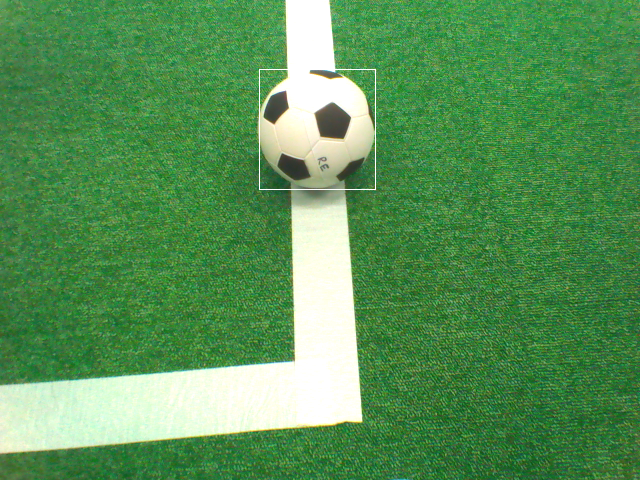

In [22]:
image = Image.open('trainval/images/alfie_lm_ball_line0010.png')
label = open('trainval/labels/alfie_lm_ball_line0010.txt').read()
label = np.fromstring(label, sep=' ')
bounding_box = label[1:]
image.size, bounding_box
cx = int(bounding_box[0] * image.size[0])
cy = int(bounding_box[1] * image.size[1])
w = int(bounding_box[2] * image.size[0])
h = int(bounding_box[3] * image.size[1])
xy = [cx - w//2, cy - h//2, cx + w//2, cy + h//2]
image_draw = ImageDraw.Draw(image)
image_draw.rectangle(xy)
image
